# Call Reports Analysis

##### Housekeeping and loading data

In [2]:
# Load packages
import os
import statsmodels.api as sm
import statsmodels.formula.api as smf
from linearmodels import PanelOLS
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
path = 'C:/Users/angel/Documents/Economics/Research/Banking Project/data/clean'
path_output = 'C:/Users/angel/Documents/Economics/Research/Banking Project/data/output'

# set colorblind theme for plots:
sns.set_theme(context='notebook', style="ticks", palette='colorblind')
sns.set_color_codes(palette='colorblind')

# Set path to be the directory:
os.chdir(path)

In [4]:
# read just the first row in the 'call_reports.csv' file:
sample = pd.read_csv('call_reports.csv', nrows=1)

# list the columns that have '_x' and '_y' in them:
cols_x = [col for col in sample.columns if '_x' in col]
cols_y = [col for col in sample.columns if '_y' in col]

problem_cols = cols_x + cols_y
problem_cols

['RCFD1754_x',
 'RCFD1773_x',
 'RCON1754_x',
 'Unnamed: 79_x',
 'Unnamed: 241_x',
 'Unnamed: 88_x',
 'RCFD1754_y',
 'RCFD1773_y',
 'RCON1754_y',
 'Unnamed: 79_y',
 'Unnamed: 241_y',
 'Unnamed: 88_y']

In [5]:
# define maturity variables:
loans_mat_vars = [
                'RCONA564', 'RCONA565', 'RCONA566', 'RCONA567', 'RCONA568', 'RCONA569',     # used
                #'RCFDA564', 'RCFDA565', 'RCFDA566', 'RCFDA567', 'RCFDA568', 'RCFDA569',     # to be tested
                # ------------------------------------------------------------------------------------------------
                'RCFDA570', 'RCFDA571', 'RCFDA572', 'RCFDA573', 'RCFDA574', 'RCFDA575',     # used 
                #'RCONA570', 'RCONA571', 'RCONA572', 'RCONA573', 'RCONA574', 'RCONA575',     # to be tested  
                ]

securities_mat_vars = [
             # --------------------------------------  Treasuries  --------------------------------------
                'RCFDA549', 'RCFDA550', 'RCFDA551', 'RCFDA552', 'RCFDA553', 'RCFDA554',     # used
                'RCONA549', 'RCONA550', 'RCONA551', 'RCONA552', 'RCONA553', 'RCONA554',     # to be tested
            # --------------------------------------  MBS  --------------------------------------
                'RCFDA555', 'RCFDA556', 'RCFDA557', 'RCFDA558', 'RCFDA559', 'RCFDA560',     # used
                'RCONA555', 'RCONA556', 'RCONA557', 'RCONA558', 'RCONA559', 'RCONA560',     # to be tested
                ]


# define the list of variables that will be used
vars = [
             # ------------------------------------------------------------------------------------------------ 
             'Date', 'IDRSSD', 'Financial Institution Name',            # Identifier Variables
             # ------------------------------------------------------------------------------------------------
            'RCON2170', 'RCFD2170',                                    # Total Assets
             # ------------------------------------------------------------------------------------------------
             'RCON2122', 'RCFD2122',                                    # Total Loans
             # ------------------------------------------------------------------------------------------------
             'RCON2200',                                                # Total Deposits
             # ------------------------------------------------------------------------------------------------
             'RCON1754', 'RCFD1754',                                    # HTM Securities Ammortized Cost
             'RCFD1754_x', 'RCFD1754_y', 'RCON1754_x', 'RCON1754_y',
             # ------------------------------------------------------------------------------------------------
             'RCON1772',                                                # AFS Securities Ammortized Cost
             # ------------------------------------------------------------------------------------------------
             'RCFD1773_x', 'RCFD1773_y', 'RCON1773',                    # AFS Securities Fair Value
             # ------------------------------------------------------------------------------------------------
             'RCON0010', 'RCFD0010',                                    # Cash and balances due from depository institutions                                                
             'RCON0071', 'RCON0081',                                    
             'RCFD0071', 'RCFD0081',                                    
             # ------------------------------------------------------------------------------------------------
             'RIAD4073', 'RIAD4200', 'RIAD4185', 'RIAD4180', 'RIAD4172',# Income Variables
             ] 

# create a list putting together 'vars', 'loans_mat_vars', and 'securities_mat_vars':
all_vars = vars + loans_mat_vars + securities_mat_vars

In [6]:
# Read file that contains only the variables of interest, specify that the column 'Date' is a date:
main = pd.read_csv('call_reports.csv', parse_dates = ['Date'], usecols=all_vars)
main['Year'] = main['Date'].dt.year

##### Checking important variables

In [7]:
print(' ---------------------------------------------- AMMORTIZED COST SECURITIES ----------------------------------------------')

# print the latest 'Date' for which either 'RCON1754_x' or 'RCON1754_y' is reported:
print('Min Date in which RCFD1754_x or RCFD1754_y are not null:', 
      main[main['RCFD1754_x'].notnull() | main['RCFD1754_y'].notnull()]['Date'].min())
print('Max Date in which RCFD1754_x or RCFD1754_y are not null:',
      main[main['RCFD1754_x'].notnull() | main['RCFD1754_y'].notnull()]['Date'].max())

print('Min Date in which RCFD1754 is not null:', main[main['RCFD1754'].notnull()]['Date'].min())
print('Max Date in which RCFD1754 is not null:', main[main['RCFD1754'].notnull()]['Date'].max())

print('------------------------------------------------------------------------------------------------')

# print the latest 'Date' for which either 'RCON1754_x' or 'RCON1754_y' is reported:
print('Min Date in which RCON1754_x or RCON1754_y are not null:',
      main[main['RCON1754_x'].notnull() | main['RCON1754_y'].notnull()]['Date'].min())
print('Max Date in which RCON1754_x or RCON1754_y are not null:',
      main[main['RCON1754_x'].notnull() | main['RCON1754_y'].notnull()]['Date'].max())

print('Min Date in which RCON1754 is not null:',main[main['RCON1754'].notnull()]['Date'].min())
print('Max Date in which RCON1754 is not null:', main[main['RCON1754'].notnull()]['Date'].max())

print('------------------------------------------------------------------------------------------------')

print('The number of rows in which RCON1754_x and RCON1754_y are both reported and different is:',
    len(main[main['RCON1754_x'].notnull() & main['RCON1754_y'].notnull() & (main['RCON1754_x']-main['RCON1754_y'] != 0)]))

print('The number of rows in which RCFD1754_x and RCFD1754_y are both reported and different is:',
    len(main[main['RCFD1754_x'].notnull() & main['RCFD1754_y'].notnull() & (main['RCFD1754_x']-main['RCFD1754_y'] != 0)]))

 ---------------------------------------------- AMMORTIZED COST SECURITIES ----------------------------------------------
Min Date in which RCFD1754_x or RCFD1754_y are not null: 2001-03-31 00:00:00
Max Date in which RCFD1754_x or RCFD1754_y are not null: 2018-12-31 00:00:00
Min Date in which RCFD1754 is not null: 2019-03-31 00:00:00
Max Date in which RCFD1754 is not null: 2024-09-30 00:00:00
------------------------------------------------------------------------------------------------
Min Date in which RCON1754_x or RCON1754_y are not null: 2001-03-31 00:00:00
Max Date in which RCON1754_x or RCON1754_y are not null: 2018-12-31 00:00:00
Min Date in which RCON1754 is not null: 2019-03-31 00:00:00
Max Date in which RCON1754 is not null: 2024-09-30 00:00:00
------------------------------------------------------------------------------------------------
The number of rows in which RCON1754_x and RCON1754_y are both reported and different is: 0
The number of rows in which RCFD1754_x and R

In [8]:
print(' ---------------------------------------------- FAIR VALUE SECURITIES ----------------------------------------------')

# print the latest 'Date' for which either 'RCON1754_x' or 'RCON1754_y' is reported:
print('Min Date in which RCFD1773_x and RCFD1773_y are not null:', 
      main[main['RCFD1773_x'].notnull() & main['RCFD1773_y'].notnull()]['Date'].min())
print('Max Date in which RCFD1773_x and RCFD1773_y are not null:',
      main[main['RCFD1773_x'].notnull() & main['RCFD1773_y'].notnull()]['Date'].max())

print('For how many non-null obs. the difference between RCFD1773_x and RCFD1773_y is not zero:',
      len(main[main['RCFD1773_x'].notnull() & 
     main['RCFD1773_y'].notnull() & 
     (main['RCFD1773_x']-main['RCFD1773_y'] != 0)]))
print('We can treat _x and _y as the same variable, since the difference is zero for all non-null obs.')
print('------------------------------------------------------------------------------------------------')
# print the amount of obs for which RCFD1773_x and RCON1773 are both reported and different:
print('For how many non-null obs. RCFD1773_x and RCON1773 are both reported and different:',
      len(main[main['RCFD1773_x'].notnull() & 
     main['RCON1773'].notnull() & 
     (main['RCFD1773_x']-main['RCON1773'] != 0)]))
# print the amount of obs for which RCFD1773_x and RCON1773 are both reported and are the same:
print('For how many non-null obs. RCFD1773_x and RCON1773 are both reported and the same:',
      len(main[main['RCFD1773_x'].notnull() & 
     main['RCON1773'].notnull() & 
     (main['RCFD1773_x']-main['RCON1773'] == 0)]))

# print the amount of obs for which RCFD1773_x is reported and RCON1773 is not:
print('For how many non-null obs. RCFD1773_x is reported and RCON1773 is not:',
      len(main[main['RCFD1773_x'].notnull() & main['RCON1773'].isnull()]))

# print the amount of obs for which RCFD1773_x is not reported and RCON1773 is:
print('For how many non-null obs. RCFD1773_x is not reported and RCON1773 is:',
      len(main[main['RCFD1773_x'].isnull() & main['RCON1773'].notnull()]))


print('------------------------------------------------------------------------------------------------')

 ---------------------------------------------- FAIR VALUE SECURITIES ----------------------------------------------
Min Date in which RCFD1773_x and RCFD1773_y are not null: 2001-03-31 00:00:00
Max Date in which RCFD1773_x and RCFD1773_y are not null: 2024-09-30 00:00:00
For how many non-null obs. the difference between RCFD1773_x and RCFD1773_y is not zero: 0
We can treat _x and _y as the same variable, since the difference is zero for all non-null obs.
------------------------------------------------------------------------------------------------
For how many non-null obs. RCFD1773_x and RCON1773 are both reported and different: 1466
For how many non-null obs. RCFD1773_x and RCON1773 are both reported and the same: 3437
For how many non-null obs. RCFD1773_x is reported and RCON1773 is not: 4686
For how many non-null obs. RCFD1773_x is not reported and RCON1773 is: 630313
------------------------------------------------------------------------------------------------


In [9]:

print(' ---------------------------------------------- Cash ----------------------------------------------')

# print the obs in which 'RCON0071' is reported and 'RCON0081' is not:
print('For how many non-null obs. RCON0071 is reported and RCON0081 is not:',
      len(main[main['RCON0071'].notnull() & main['RCON0081'].isnull()]))

# print the obs in which 'RCON0071' and 'RCON0081' are both reported:
print('For how many non-null obs. RCON0071 and RCON0081 are both reported:',
      len(main[main['RCON0071'].notnull() & main['RCON0081'].notnull()]))

# print the obs in which 'RCON0010', 'RCON0071', and 'RCON0081' are all reported:
print('For how many non-null obs. RCON0010, RCON0071, and RCON0081 are all reported:',
      len(main[main['RCON0010'].notnull() & main['RCON0071'].notnull() & main['RCON0081'].notnull()]))

# print the obs in which 'RCON0010' is reported and 'RCON0071' or 'RCON0081' are not:
print('For how many non-null obs. RCON0010 is reported and RCON0071 or RCON0081 are not:',
      len(main[main['RCON0010'].notnull() & (main['RCON0071'].isnull() | main['RCON0081'].isnull())]))

# print the obs in which 'RCON0010' is not reported and 'RCON0071' and 'RCON0081' are:
print('For how many non-null obs. RCON0010 is not reported and RCON0071 and RCON0081 are:',
      len(main[main['RCON0010'].isnull() & main['RCON0071'].notnull() & main['RCON0081'].notnull()]))

# print the obs in which none is reported:
print('For how many non-null obs. none of RCON0010, RCON0071, and RCON0081 are reported:',
      len(main[main['RCON0010'].isnull() & main['RCON0071'].isnull() & main['RCON0081'].isnull()]))

print('------------------------------------------------------------------------------------------------')


 ---------------------------------------------- Cash ----------------------------------------------
For how many non-null obs. RCON0071 is reported and RCON0081 is not: 0
For how many non-null obs. RCON0071 and RCON0081 are both reported: 630313
For how many non-null obs. RCON0010, RCON0071, and RCON0081 are all reported: 472858
For how many non-null obs. RCON0010 is reported and RCON0071 or RCON0081 are not: 9506
For how many non-null obs. RCON0010 is not reported and RCON0071 and RCON0081 are: 157455
For how many non-null obs. none of RCON0010, RCON0071, and RCON0081 are reported: 83
------------------------------------------------------------------------------------------------


In [10]:
print(' --------------------------- Maturity for Securities ----------------------------------------')
# print the last 3 digits from 'securities_mat_vars':
last_digits = sorted(list(set([var[-3:] for var in securities_mat_vars])))

for x in last_digits:
    print(' --------------------------------------------------------------------------------------------')
    print('For x =', x)
    print(f'Entries in which both are null:', len(main[(main[f'RCONA{x}'].isnull()) & (main[f'RCFDA{x}'].isnull())]))
    print(f'Entries in which only RCFDA{x} is NOT null:', len(main[(main[f'RCONA{x}'].isnull()) & (main[f'RCFDA{x}'].notnull())]))
    print(f'Entries in which only RCONA{x} is NOT null:', len(main[(main[f'RCONA{x}'].notnull()) & (main[f'RCFDA{x}'].isnull())]))
    print(f'Entries in which none is null:', len(main[(main[f'RCONA{x}'].notnull()) & (main[f'RCFDA{x}'].notnull())]))

 --------------------------- Maturity for Securities ----------------------------------------
 --------------------------------------------------------------------------------------------
For x = 549
Entries in which both are null: 0
Entries in which only RCFDA549 is NOT null: 9589
Entries in which only RCONA549 is NOT null: 630313
Entries in which none is null: 0
 --------------------------------------------------------------------------------------------
For x = 550
Entries in which both are null: 0
Entries in which only RCFDA550 is NOT null: 9589
Entries in which only RCONA550 is NOT null: 630313
Entries in which none is null: 0
 --------------------------------------------------------------------------------------------
For x = 551
Entries in which both are null: 2
Entries in which only RCFDA551 is NOT null: 9589
Entries in which only RCONA551 is NOT null: 630311
Entries in which none is null: 0
 --------------------------------------------------------------------------------------

In [11]:
print(' --------------------------- Maturity for Loans ----------------------------------------')
print('-------------------------------------- Less than 3m --------------------------------------')
print(f'Entries in which both are null:', len(main[(main['RCONA564'].isnull()) & (main['RCFDA570'].isnull())]))
print(f'Entries in which only RCFDA570 is NOT null:', len(main[(main['RCONA564'].isnull()) & (main['RCFDA570'].notnull())]))
print(f'Entries in which only RCONA564 is NOT null:', len(main[(main['RCONA564'].notnull()) & (main['RCFDA570'].isnull())]))
print(f'Entries in which none is null:', len(main[(main['RCONA564'].notnull()) & (main['RCFDA570'].notnull())]))
print('-------------------------------------- Between 3-12m --------------------------------------')
print(f'Entries in which both are null:', len(main[(main['RCONA565'].isnull()) & (main['RCFDA571'].isnull())]))
print(f'Entries in which only RCFDA571 is NOT null:', len(main[(main['RCONA565'].isnull()) & (main['RCFDA571'].notnull())]))
print(f'Entries in which only RCONA565 is NOT null:', len(main[(main['RCONA565'].notnull()) & (main['RCFDA571'].isnull())]))
print(f'Entries in which none is null:', len(main[(main['RCONA565'].notnull()) & (main['RCFDA571'].notnull())]))
print('-------------------------------------- Between 12-36m --------------------------------------')
print(f'Entries in which both are null:', len(main[(main['RCONA566'].isnull()) & (main['RCFDA572'].isnull())]))
print(f'Entries in which only RCFDA572 is NOT null:', len(main[(main['RCONA566'].isnull()) & (main['RCFDA572'].notnull())]))
print(f'Entries in which only RCONA566 is NOT null:', len(main[(main['RCONA566'].notnull()) & (main['RCFDA572'].isnull())]))
print(f'Entries in which none is null:', len(main[(main['RCONA566'].notnull()) & (main['RCFDA572'].notnull())]))
print('-------------------------------------- Between 36-60m --------------------------------------')
print(f'Entries in which both are null:', len(main[(main['RCONA567'].isnull()) & (main['RCFDA573'].isnull())]))
print(f'Entries in which only RCFDA573 is NOT null:', len(main[(main['RCONA567'].isnull()) & (main['RCFDA573'].notnull())]))
print(f'Entries in which only RCONA567 is NOT null:', len(main[(main['RCONA567'].notnull()) & (main['RCFDA573'].isnull())]))
print(f'Entries in which none is null:', len(main[(main['RCONA567'].notnull()) & (main['RCFDA573'].notnull())]))
print('-------------------------------------- Between 60-180m --------------------------------------')
print(f'Entries in which both are null:', len(main[(main['RCONA568'].isnull()) & (main['RCFDA574'].isnull())]))
print(f'Entries in which only RCFDA574 is NOT null:', len(main[(main['RCONA568'].isnull()) & (main['RCFDA574'].notnull())]))
print(f'Entries in which only RCONA568 is NOT null:', len(main[(main['RCONA568'].notnull()) & (main['RCFDA574'].isnull())]))
print(f'Entries in which none is null:', len(main[(main['RCONA568'].notnull()) & (main['RCFDA574'].notnull())]))
print('-------------------------------------- More than 180m --------------------------------------')
print(f'Entries in which both are null:', len(main[(main['RCONA569'].isnull()) & (main['RCFDA575'].isnull())]))
print(f'Entries in which only RCFDA575 is NOT null:', len(main[(main['RCONA569'].isnull()) & (main['RCFDA575'].notnull())]))
print(f'Entries in which only RCONA569 is NOT null:', len(main[(main['RCONA569'].notnull()) & (main['RCFDA575'].isnull())]))
print(f'Entries in which none is null:', len(main[(main['RCONA569'].notnull()) & (main['RCFDA575'].notnull())]))

 --------------------------- Maturity for Loans ----------------------------------------
-------------------------------------- Less than 3m --------------------------------------
Entries in which both are null: 0
Entries in which only RCFDA570 is NOT null: 0
Entries in which only RCONA564 is NOT null: 630313
Entries in which none is null: 9589
-------------------------------------- Between 3-12m --------------------------------------
Entries in which both are null: 0
Entries in which only RCFDA571 is NOT null: 0
Entries in which only RCONA565 is NOT null: 630313
Entries in which none is null: 9589
-------------------------------------- Between 12-36m --------------------------------------
Entries in which both are null: 0
Entries in which only RCFDA572 is NOT null: 0
Entries in which only RCONA566 is NOT null: 630313
Entries in which none is null: 9589
-------------------------------------- Between 36-60m --------------------------------------
Entries in which both are null: 0
Entries

##### Basic Definitions

###### Balance sheet definitions

In [12]:
main['RCON1754_right'] = main['RCON1754_x'].combine_first(main['RCON1754'])
main['RCFD1754_right'] = main['RCFD1754_x'].combine_first(main['RCFD1754'])

# Create the new column '1754_right' and initialize with NaN
main['1754_right'] = np.nan

# Case 1: Both columns are not null
mask_both_notnull = main['RCFD1754_right'].notna() & main['RCON1754_right'].notna()
main.loc[mask_both_notnull, '1754_right'] = main.loc[mask_both_notnull, ['RCFD1754_right', 'RCON1754_right']].min(axis=1)

# Case 2: Only one column is not null
mask_col1_notnull = main['RCFD1754_right'].notna() & main['RCON1754_right'].isna()
main.loc[mask_col1_notnull, '1754_right'] = main.loc[mask_col1_notnull, 'RCFD1754_right']

mask_col2_notnull = main['RCON1754_right'].notna() & main['RCFD1754_right'].isna()
main.loc[mask_col2_notnull, '1754_right'] = main.loc[mask_col2_notnull, 'RCON1754_right']

# Case 3: Both columns are null (already handled by initialization to NaN)


In [13]:
print(main['RCON1754_right'].describe())
print(main['RCFD1754_right'].describe())
print(main['1754_right'].describe())

count    6.352160e+05
mean     9.870183e+04
std      4.310712e+06
min      0.000000e+00
25%      0.000000e+00
50%      0.000000e+00
75%      2.419000e+03
max      6.830540e+08
Name: RCON1754_right, dtype: float64
count    9.589000e+03
mean     5.765784e+06
std      3.534790e+07
min      0.000000e+00
25%      0.000000e+00
50%      1.258600e+04
75%      3.546600e+05
max      6.830540e+08
Name: RCFD1754_right, dtype: float64
count    6.399020e+05
mean     1.072001e+05
std      4.359587e+06
min      0.000000e+00
25%      0.000000e+00
50%      0.000000e+00
75%      2.494000e+03
max      6.830540e+08
Name: 1754_right, dtype: float64


In [14]:
main[main['RCON1754_right'].notnull() & 
     main['RCFD1754_right'].notnull() & 
     (main['RCON1754_right']-main['RCFD1754_right'] != 0)][['Date', 'RCON1754_right', 'RCFD1754_right', '1754_right']]

,Date,RCON1754_right,RCFD1754_right,1754_right
73687,2010-03-31,17935977.0,19830720.0,17935977.0
74601,2010-03-31,852099.0,885365.0,852099.0
74611,2010-03-31,1247462.0,1247561.0,1247462.0
74706,2010-03-31,11095.0,13014.0,11095.0
74773,2010-03-31,0.0,28413.0,0.0
...,...,...,...,...
637906,2023-12-31,8485388.0,8485389.0,8485388.0
637919,2023-12-31,47931.0,47946.0,47931.0
638179,2023-12-31,4984830.0,4994835.0,4984830.0
638399,2023-12-31,358532000.0,369942000.0,358532000.0


In [15]:
# create 'Securities AC' summing RCON1754 and RCON1772. If both are NaN, fill with NaN. If only one is available, use that one. If both 
# are available sum them:
main['Securities AC'] = main[['1754_right', 'RCON1772']].apply(
    lambda row: np.nan if pd.isna(row['1754_right']) and pd.isna(row['RCON1772']) else (row.fillna(0).sum()),
    axis=1
)
main['Securities AC'] = main['Securities AC'].mask(main['Securities AC'] <= 0, np.nan)
print(main['Securities AC'].describe())

count    6.192770e+05
mean     2.205622e+05
std      4.532424e+06
min      1.000000e+00
25%      1.113100e+04
50%      2.878200e+04
75%      7.518300e+04
max      6.830540e+08
Name: Securities AC, dtype: float64


In [16]:
main['1773_right'] = main['RCON1773'].combine_first(main['RCFD1773_x'])
# mask the <= 0 values with NaN:
main['1773_right'] = main['1773_right'].mask(main['1773_right'] <= 0, np.nan)
print(main['1773_right'].describe())

count    5.860780e+05
mean     3.501374e+05
std      5.407126e+06
min      1.000000e+00
25%      1.042600e+04
50%      2.752400e+04
75%      7.273300e+04
max      4.479270e+08
Name: 1773_right, dtype: float64


In [17]:
# Define 'Total Securities' using the sum of '1754_right' and '1773_right' (amortized cost + fair value):
main['Total Securities'] = main[['1754_right', '1773_right']].apply(
    lambda row: np.nan if pd.isna(row['1754_right']) and pd.isna(row['1773_right']) else (row.fillna(0).sum()),
    axis=1
)
main['Total Securities'] = main['Total Securities'].mask(main['Total Securities'] <= 0, np.nan)
print(main['Total Securities'].describe())

count    6.225050e+05
mean     4.398445e+05
std      8.449511e+06
min      1.000000e+00
25%      1.129900e+04
50%      2.919000e+04
75%      7.686000e+04
max      9.299180e+08
Name: Total Securities, dtype: float64


In [18]:
# create 'Total Assets' variable. If the bank fills the FFIEC41 (only RCON series available). Large banks may also have the 
# RCFD series available. If both are NaN, fill with NaN. If both are available, use the RCON series. If only RCFD is available,
# use RCFD. 
main['Total Assets'] = main['RCON2170'].combine_first(main['RCFD2170'])

print(main['RCON2170'].describe())
print(main['RCFD2170'].describe())
print(main['Total Assets'].describe())

main['Total Assets'] = main['Total Assets'].mask(main['Total Assets'] == 0, np.nan)

count    6.351330e+05
mean     9.755156e+05
std      1.244043e+07
min      0.000000e+00
25%      6.975000e+04
50%      1.522690e+05
75%      3.686870e+05
max      1.445545e+09
Name: RCON2170, dtype: float64
count    9.589000e+03
mean     1.036920e+08
std      3.150145e+08
min      4.264000e+03
25%      1.455077e+06
50%      1.235404e+07
75%      6.758438e+07
max      3.584105e+09
Name: RCFD2170, dtype: float64
count    6.399020e+05
mean     2.114301e+06
std      3.944563e+07
min      0.000000e+00
25%      7.020225e+04
50%      1.539290e+05
75%      3.772038e+05
max      3.584105e+09
Name: Total Assets, dtype: float64


In [19]:
main.loc[:, 'Securities Share'] = main['Total Securities'] / main['Total Assets']

In [20]:
main['Securities Share'].describe()

count    6.225050e+05
mean     2.269777e-01
std      1.569241e-01
min      7.399239e-09
25%      1.093705e-01
50%      1.981180e-01
75%      3.137277e-01
max      2.642542e+00
Name: Securities Share, dtype: float64

In [21]:
main[main['Securities Share']>1][['Date', 'IDRSSD', 'Financial Institution Name', 'Total Securities', 'Total Assets', 'Securities Share']]

,Date,IDRSSD,Financial Institution Name,Total Securities,Total Assets,Securities Share
337820,2002-09-30,656733.0,"MB FINANCIAL BANK, NATIONAL ASSOCIATION",852196.0,322491.0,2.642542


In [22]:
main['Total Loans'] = main['RCON2122'].combine_first(main['RCFD2122'])

print(main['RCON2122'].describe())
print(main['RCFD2122'].describe())
print(main['Total Loans'].describe())

main['Total Loans'] = main['Total Loans'].mask(main['Total Loans'] == 0, np.nan)
print(main['Total Loans'].describe())

count    6.399020e+05
mean     1.115855e+06
std      1.638202e+07
min      0.000000e+00
25%      3.991900e+04
50%      9.623600e+04
75%      2.468268e+05
max      1.219816e+09
Name: RCON2122, dtype: float64
count    9.589000e+03
mean     5.150065e+07
std      1.402738e+08
min      0.000000e+00
25%      7.367520e+05
50%      7.377421e+06
75%      3.715684e+07
max      1.353071e+09
Name: RCFD2122, dtype: float64
count    6.399020e+05
mean     1.115855e+06
std      1.638202e+07
min      0.000000e+00
25%      3.991900e+04
50%      9.623600e+04
75%      2.468268e+05
max      1.219816e+09
Name: Total Loans, dtype: float64
count    6.294910e+05
mean     1.134310e+06
std      1.651630e+07
min      1.000000e+00
25%      4.195200e+04
50%      9.887900e+04
75%      2.515910e+05
max      1.219816e+09
Name: Total Loans, dtype: float64


C:\Users\angel\AppData\Local\Temp\ipykernel_9444\2193418771.py:1: FutureWarning: The behavior of array concatenation with empty entries is deprecated. In a future version, this will no longer exclude empty items when determining the result dtype. To retain the old behavior, exclude the empty entries before the concat operation.
  main['Total Loans'] = main['RCON2122'].combine_first(main['RCFD2122'])


In [23]:
# create 'Total Deposits'
main.rename(columns = {'RCON2200':'Total Deposits'}, inplace = True)
main['Total Deposits'] = main['Total Deposits'].mask(main['Total Deposits'] == 0, np.nan)
print(main['Total Deposits'].describe())

count    6.333120e+05
mean     1.459541e+06
std      2.552438e+07
min      1.000000e+00
25%      5.953400e+04
50%      1.298275e+05
75%      3.129310e+05
max      2.201118e+09
Name: Total Deposits, dtype: float64


In [24]:
# create 'Cash' summing RCON0020 and RCON0080:
main['Cash'] = (main['RCON0071']+main['RCON0081']).combine_first(main['RCON0010'])
main['Cash'] = main['Cash'].mask(main['Cash'] <= 0, np.nan)
print(main['Cash'].describe())

count    6.390710e+05
mean     1.715995e+05
std      4.239690e+06
min      1.000000e+00
25%      3.374000e+03
50%      8.435000e+03
75%      2.253550e+04
max      5.436850e+08
Name: Cash, dtype: float64


In [25]:
# create 'Cash Share' variable:
main.loc[:, 'Cash Share'] = main['Cash'] / main['Total Assets']
print(main['Cash Share'].describe())

count    6.390710e+05
mean     8.074127e-02
std      9.582002e-02
min      3.945225e-07
25%      2.846594e-02
50%      4.894672e-02
75%      9.637697e-02
max      1.000000e+00
Name: Cash Share, dtype: float64


In [26]:
main.loc[:, 'Loans Share'] = main['Total Loans'] / main['Total Assets']
#mask loans share > 1 with NaN:
main['Loans Share'] = main['Loans Share'].mask(main['Loans Share'] > 1, np.nan)
print(main['Loans Share'].describe())

count    6.293540e+05
mean     6.335982e-01
std      1.623766e-01
min      5.649079e-07
25%      5.379652e-01
50%      6.576725e-01
75%      7.530094e-01
max      9.998557e-01
Name: Loans Share, dtype: float64


In [27]:
# Maturity of Treasuries:
main['Treasuries (3M-)'] = main['RCONA549'].combine_first(main['RCFDA549'])
main['Treasuries (3M-1Y)'] = main['RCONA550'].combine_first(main['RCFDA550'])
main['Treasuries (1Y-3Y)'] = main['RCONA551'].combine_first(main['RCFDA551'])
main['Treasuries (3Y-5Y)'] = main['RCONA552'].combine_first(main['RCFDA552'])
main['Treasuries (5Y-15Y)'] = main['RCONA553'].combine_first(main['RCFDA553'])
main['Treasuries (15Y+)'] = main['RCONA554'].combine_first(main['RCFDA554'])

print(main['Treasuries (3M-)'].describe())

# Maturity of MBS:
main['MBS (3M-)'] = main['RCONA555'].combine_first(main['RCFDA555'])
main['MBS (3M-1Y)'] = main['RCONA556'].combine_first(main['RCFDA556'])
main['MBS (1Y-3Y)'] = main['RCONA557'].combine_first(main['RCFDA557'])
main['MBS (3Y-5Y)'] = main['RCONA558'].combine_first(main['RCFDA558'])
main['MBS (5Y-15Y)'] = main['RCONA559'].combine_first(main['RCFDA559'])
main['MBS (15Y+)'] = main['RCONA560'].combine_first(main['RCFDA560'])

print(main['MBS (3M-)'].describe())

# Maturity of overall Securities:
main['Securities (3M-)'] = main['Treasuries (3M-)'] + main['MBS (3M-)']
main['Securities (3M-1Y)'] = main['Treasuries (3M-1Y)'] + main['MBS (3M-1Y)']
main['Securities (1Y-3Y)'] = main['Treasuries (1Y-3Y)'] + main['MBS (1Y-3Y)']
main['Securities (3Y-5Y)'] = main['Treasuries (3Y-5Y)'] + main['MBS (3Y-5Y)']
main['Securities (5Y-15Y)'] = main['Treasuries (5Y-15Y)'] + main['MBS (5Y-15Y)']
main['Securities (15Y+)'] = main['Treasuries (15Y+)'] + main['MBS (15Y+)']

print(main['Securities (3M-)'].describe())

# Maturity of overall Loans:
main['Loans (3M-)'] = main['RCONA564'].combine_first(main['RCFDA570'])
main['Loans (3M-1Y)'] = main['RCONA565'].combine_first(main['RCFDA571'])
main['Loans (1Y-3Y)'] = main['RCONA566'].combine_first(main['RCFDA572'])    
main['Loans (3Y-5Y)'] = main['RCONA567'].combine_first(main['RCFDA573'])
main['Loans (5Y-15Y)'] = main['RCONA568'].combine_first(main['RCFDA574'])
main['Loans (15Y+)'] = main['RCONA569'].combine_first(main['RCFDA575'])

print(main['Loans (3M-)'].describe())


count    6.399020e+05
mean     3.902802e+04
std      1.015064e+06
min      0.000000e+00
25%      0.000000e+00
50%      4.460000e+02
75%      2.191000e+03
max      1.059389e+08
Name: Treasuries (3M-), dtype: float64
count    6.399020e+05
mean     3.424015e+03
std      7.873984e+04
min      0.000000e+00
25%      0.000000e+00
50%      0.000000e+00
75%      6.400000e+01
max      1.018429e+07
Name: MBS (3M-), dtype: float64
count    6.399020e+05
mean     4.245204e+04
std      1.030878e+06
min      0.000000e+00
25%      0.000000e+00
50%      6.040000e+02
75%      2.903000e+03
max      1.063704e+08
Name: Securities (3M-), dtype: float64
count    6.399020e+05
mean     1.954458e+04
std      4.643297e+05
min      0.000000e+00
25%      2.580000e+02
50%      1.141000e+03
75%      3.724000e+03
max      6.511200e+07
Name: Loans (3M-), dtype: float64


C:\Users\angel\AppData\Local\Temp\ipykernel_9444\4252648859.py:32: FutureWarning: The behavior of array concatenation with empty entries is deprecated. In a future version, this will no longer exclude empty items when determining the result dtype. To retain the old behavior, exclude the empty entries before the concat operation.
  main['Loans (3M-)'] = main['RCONA564'].combine_first(main['RCFDA570'])
C:\Users\angel\AppData\Local\Temp\ipykernel_9444\4252648859.py:33: FutureWarning: The behavior of array concatenation with empty entries is deprecated. In a future version, this will no longer exclude empty items when determining the result dtype. To retain the old behavior, exclude the empty entries before the concat operation.
  main['Loans (3M-1Y)'] = main['RCONA565'].combine_first(main['RCFDA571'])
C:\Users\angel\AppData\Local\Temp\ipykernel_9444\4252648859.py:34: FutureWarning: The behavior of array concatenation with empty entries is deprecated. In a future version, this will no long

In [28]:
# create the 'Treasury Maturity' variable:

main['Treasury Maturity'] = ((
                            main['Treasuries (3M-)']*1.5 + 
                            main['Treasuries (3M-1Y)']*7.5 + 
                            main['Treasuries (1Y-3Y)']*24 + 
                            main['Treasuries (3Y-5Y)']*48 + 
                            main['Treasuries (5Y-15Y)']*120 + 
                            main['Treasuries (15Y+)']*180
                            ) / (
                                main['Treasuries (3M-)']        + 
                                main['Treasuries (3M-1Y)']      + 
                                main['Treasuries (1Y-3Y)']      + 
                                main['Treasuries (3Y-5Y)']      + 
                                main['Treasuries (5Y-15Y)']     + 
                                main['Treasuries (15Y+)']
                            )) / 12

print(main['Treasury Maturity'].describe())

# create the 'Security Maturity' variable:
main['Security Maturity'] = ((
                            main['Securities (3M-)']*1.5 + 
                            main['Securities (3M-1Y)']*7.5 + 
                            main['Securities (1Y-3Y)']*24 + 
                            main['Securities (3Y-5Y)']*48 + 
                            main['Securities (5Y-15Y)']*120 + 
                            main['Securities (15Y+)']*180
                            ) / (
                                main['Securities (3M-)']        + 
                                main['Securities (3M-1Y)']      + 
                                main['Securities (1Y-3Y)']      + 
                                main['Securities (3Y-5Y)']      + 
                                main['Securities (5Y-15Y)']     + 
                                main['Securities (15Y+)']
                            )) / 12

print(main['Security Maturity'].describe())

# create the 'Loan Maturity' variable:
main['Loan Maturity'] = ((
                            main['Loans (3M-)']*1.5 + 
                            main['Loans (3M-1Y)']*7.5 + 
                            main['Loans (1Y-3Y)']*24 + 
                            main['Loans (3Y-5Y)']*48 + 
                            main['Loans (5Y-15Y)']*120 + 
                            main['Loans (15Y+)']*180
                            ) / (
                                main['Loans (3M-)']        + 
                                main['Loans (3M-1Y)']      + 
                                main['Loans (1Y-3Y)']      + 
                                main['Loans (3Y-5Y)']      + 
                                main['Loans (5Y-15Y)']     + 
                                main['Loans (15Y+)']
                            )) / 12

print(main['Loan Maturity'].describe())

count    606419.000000
mean          5.627869
std           3.144099
min           0.125000
25%           3.017650
50%           5.386732
75%           7.999813
max          15.000000
Name: Treasury Maturity, dtype: float64
count    619861.000000
mean          6.501768
std           3.320158
min           0.125000
25%           3.798722
50%           6.512730
75%           9.039213
max          15.000000
Name: Security Maturity, dtype: float64
count    619545.000000
mean          5.386390
std           3.360806
min           0.125000
25%           2.718495
50%           4.462871
75%           7.704278
max          15.000000
Name: Loan Maturity, dtype: float64


In [29]:
# compute the 'Asset Maturity' variable. This is the weighted average of the maturity of securities and loans:
main['Asset Maturity'] = (main['Security Maturity']*main['Total Securities'] + main['Loan Maturity']*main['Total Loans']) / (main['Total Assets'])
print(main['Asset Maturity'].describe())

count    604752.000000
mean          4.911003
std           2.530656
min           0.018866
25%           2.917658
50%           4.481722
75%           6.605185
max          43.751082
Name: Asset Maturity, dtype: float64


###### Income Definitions

In [30]:
# compute the variable above avoiding the SettingWithCopyWarning:
main.loc[:, 'Deposit Expenditure'] = (main['RIAD4073'].fillna(0) - main['RIAD4200'].fillna(0) - main['RIAD4185'].fillna(0) - 
                                      main['RIAD4180'].fillna(0) - main['RIAD4172'].fillna(0))

In [31]:
main.loc[:, 'Actual Deposit Exp'] = main.groupby(['IDRSSD', 'Year'])['Deposit Expenditure'].diff().fillna(main['Deposit Expenditure'])
main.loc[:, 'Actual Deposit Exp'] = main['Actual Deposit Exp'].mask(main['Actual Deposit Exp'] <= 0, np.nan)
main['Actual Deposit Exp'].describe()

count    6.299100e+05
mean     3.434562e+03
std      6.287334e+04
min      1.000000e+00
25%      1.460000e+02
50%      3.650000e+02
75%      9.450000e+02
max      9.521000e+06
Name: Actual Deposit Exp, dtype: float64

In [32]:
# Compute deposit rates:
main.loc[:,'Deposit Rate'] = main['Actual Deposit Exp'] / main['Total Deposits']
print(main['Deposit Rate'].describe())

count    6.298000e+05
mean     3.845853e-03
std      4.381545e-02
min      1.480123e-07
25%      1.346747e-03
50%      3.006740e-03
75%      5.482508e-03
max      3.327273e+01
Name: Deposit Rate, dtype: float64


In [33]:
# Create an extra column in df3 with the avg. deposit rate per Date:
main.loc[:,'Avg. Deposit Rate'] = main.groupby('Date')['Deposit Rate'].transform('mean')
main.loc[:,'Std. Deposit Rate'] = main.groupby('Date')['Deposit Rate'].transform('std')
main.loc[:,'R_hat'] = (main['Deposit Rate'] - main['Avg. Deposit Rate']) #/ main['Std. Deposit Rate']
main['R_hat'].describe()

count    6.298000e+05
mean    -2.961535e-20
std      4.374611e-02
min     -1.032945e-02
25%     -8.214249e-04
50%     -1.705193e-04
75%      5.943373e-04
max      3.326658e+01
Name: R_hat, dtype: float64

In [34]:
balanced_panel = 0

if balanced_panel == 1:

    # Step 1: Count the total number of unique dates in the dataset
    total_dates = main['Date'].nunique()
    print('Number of dates:', total_dates)

    # Step 2: Count the number of unique dates each bank shows up
    bank_date_counts = main.groupby('IDRSSD')['Date'].nunique()
    print('Banks that show up in all dates:', sum(bank_date_counts==total_dates))

    # Step 3: Identify banks that are present in all dates with positive 'Total Deposit':
    banks = bank_date_counts[bank_date_counts == total_dates].index
    main = main[main['IDRSSD'].isin(banks)]


## SVB Story

C:\Users\angel\AppData\Local\Temp\ipykernel_9444\2458550508.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  svb_date.loc[:, 'Log Assets'] = np.log(svb_date['Total Assets'])


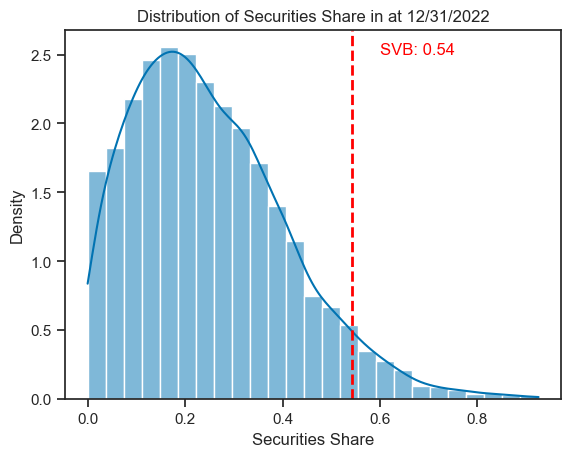

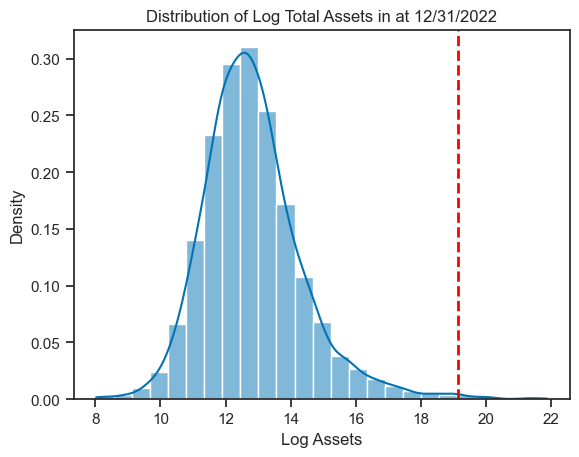

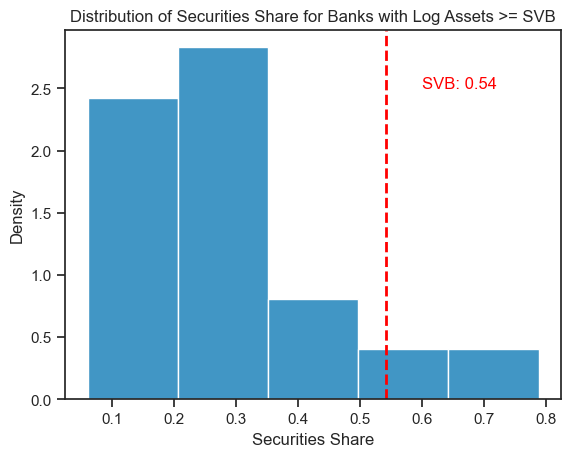

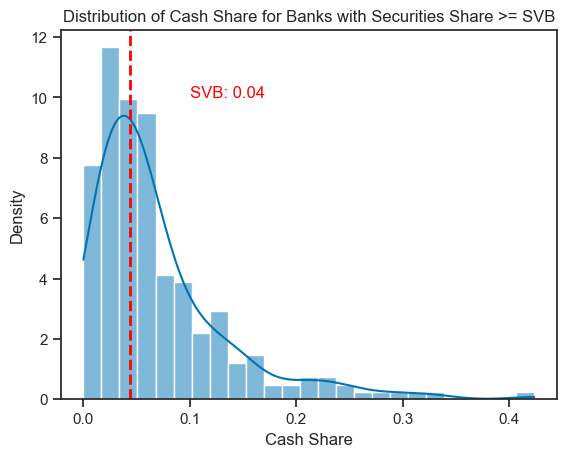

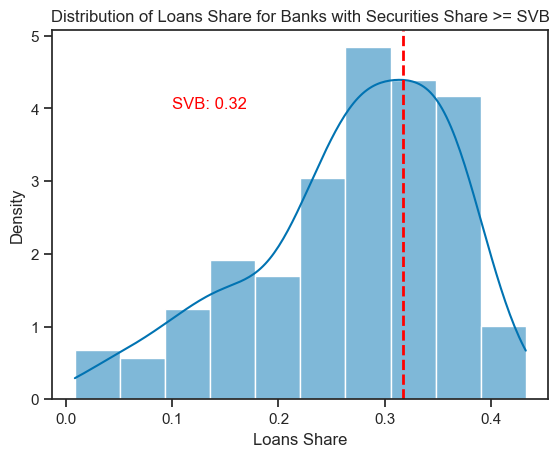

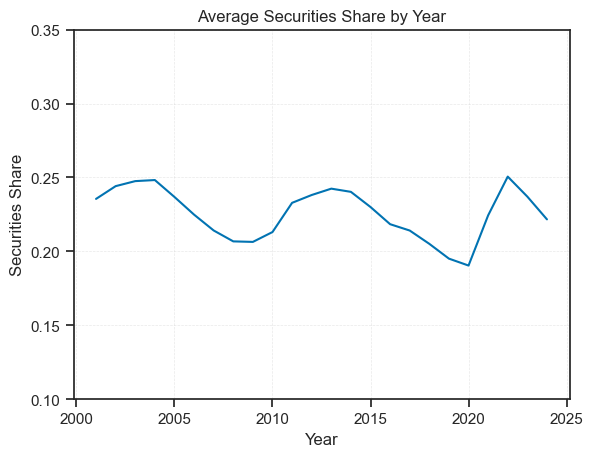

In [35]:
# SVB story: 
svb_date = main[(main['Date'] == '2022-12-31')]
# create a log of the total assets using .loc:
svb_date.loc[:, 'Log Assets'] = np.log(svb_date['Total Assets'])
svb_share = svb_date[svb_date['IDRSSD'] == 802866]['Securities Share'].values[0]
svb_share_cash = svb_date[svb_date['IDRSSD'] == 802866]['Cash Share'].values[0]
svb_share_loans = svb_date[svb_date['IDRSSD'] == 802866]['Loans Share'].values[0]
sns.histplot(data=svb_date, x='Securities Share', bins=25, kde=True, stat='density')
# plot a vertical line at the ID=802866 (SVB):
plt.axvline(x=svb_date[svb_date['IDRSSD'] == 802866]['Securities Share'].values[0], color='red', linestyle='--', linewidth=2)
# print the value of the SVB securities share:
plt.text(x=0.6,
          y=2.5, s=f'SVB: {np.round(svb_share,2)}', color='red')
plt.title('Distribution of Securities Share in at 12/31/2022')
plt.show()

sns.histplot(data=svb_date, x='Log Assets', bins=25, kde=True, stat='density')
# plot a vertical line at the ID=802866 (SVB):
plt.axvline(x=svb_date[svb_date['IDRSSD'] == 802866]['Log Assets'].values[0], color='red', linestyle='--', linewidth=2)
# print the value of the SVB securities share:
plt.title('Distribution of Log Total Assets in at 12/31/2022')
plt.show()

# plot the distribution of the securities share for the banks with log assets larger than SVB:
sns.histplot(data=svb_date[svb_date['Log Assets'] >= svb_date[svb_date['IDRSSD'] == 802866]['Log Assets'].values[0]],
              x='Securities Share', bins=5, kde=False, stat='density')
plt.title('Distribution of Securities Share for Banks with Log Assets >= SVB')
# plot a vertical line at the ID=802866 (SVB):
plt.axvline(x=svb_date[svb_date['IDRSSD'] == 802866]['Securities Share'].values[0], color='red', linestyle='--', linewidth=2)
# print the value of the SVB securities share:
plt.text(x=0.6,
          y=2.5, s=f'SVB: {np.round(svb_share,2)}', color='red')
plt.xlabel('Securities Share')
plt.ylabel('Density')
plt.show()

# plot a histogram of the 'Cash Share' variable for banks with 'Securities Share' greater than SVB:
sns.histplot(data=svb_date[svb_date['Securities Share'] >= svb_share], x='Cash Share', bins=25, kde=True, stat='density')
plt.title('Distribution of Cash Share for Banks with Securities Share >= SVB')
# plot a vertical line at the ID=802866 (SVB):
plt.axvline(x=svb_date[svb_date['IDRSSD'] == 802866]['Cash Share'].values[0], color='red', linestyle='--', linewidth=2)
# print the value of the SVB securities share:
plt.text(x=0.1,
          y=10, s=f'SVB: {np.round(svb_share_cash,2)}', color='red')

plt.xlabel('Cash Share')
plt.ylabel('Density')
plt.show()

# plot a histogram of the 'Loan Share' variable for banks with 'Securities Share' greater than SVB:
sns.histplot(data=svb_date[svb_date['Securities Share'] >= svb_share], x='Loans Share', bins=10, kde=True, stat='density')
plt.title('Distribution of Loans Share for Banks with Securities Share >= SVB')
# plot a vertical line at the ID=802866 (SVB):
plt.axvline(x=svb_date[svb_date['IDRSSD'] == 802866]['Loans Share'].values[0], color='red', linestyle='--', linewidth=2)
# print the value of the SVB securities share:
plt.text(x=0.1,
          y=4, s=f'SVB: {np.round(svb_share_loans,2)}', color='red')
plt.xlabel('Loans Share')
plt.ylabel('Density')
plt.show()

# plot the average securities share by year:
sns.lineplot(data=main.groupby('Year').agg({'Securities Share': 'mean'}).reset_index(), x='Year', y='Securities Share')
plt.title('Average Securities Share by Year')
plt.xlabel('Year')
plt.ylabel('Securities Share')
plt.ylim(0.1, 0.35)
plt.grid(True, linestyle='--', alpha=0.5, linewidth=0.5, color='lightgrey')
plt.show()

## Aggregate Data

In [36]:
# Load monetary policy shock data:
mp_shocks = pd.read_csv('brw-shock-series.csv')

# Drop column that has 'Unnamed' in it:
mp_shocks = mp_shocks.loc[:, ~mp_shocks.columns.str.contains('^Unnamed')]

# keep only the first 4 columns:
mp_shocks = mp_shocks.iloc[:, 0:4]

# rename columns:
mp_shocks.columns = mp_shocks.columns.str.replace(' (updated)', '')
mp_shocks.loc[:, 'month'] = mp_shocks['month'].str.replace('m', '-')
mp_shocks = mp_shocks[['month', 'BRW_monthly']]

# drop the 'NaT' row:
mp_shocks = mp_shocks.dropna()
mp_shocks['month'] = pd.to_datetime(mp_shocks['month'], format='%Y-%m')
# compute the quarterly average of the monthly shocks:
mp_shocks['quarter'] = mp_shocks['month'].dt.to_period('Q')
mp_shocks['BRW_quarterly'] = mp_shocks.groupby('quarter')['BRW_monthly'].transform('sum')

# keep only one observation for 'month' and 'BRW_quarterly' for each quarter:
mp_shocks = mp_shocks.drop_duplicates(subset='quarter', keep='first')
mp_shocks['Date'] = mp_shocks['month'] - pd.DateOffset(days = 1)

mp_shocks = mp_shocks[['Date', 'BRW_quarterly']]
mp_shocks.rename(columns={'BRW_quarterly': 'MP Shocks'}, inplace=True)

mp_shocks.loc[:,'Positive FF Shock'] = 0
mp_shocks.loc[mp_shocks['MP Shocks'] > 0, 'Positive FF Shock'] = 1

In [62]:
# Load the Excess Bond Premium data:
ebp = pd.read_csv('ebp_csv.csv')

In [64]:
# create a quarter column:
ebp['quarter'] = pd.to_datetime(ebp['date']).dt.to_period('Q')

In [66]:
# generate ebp quarterly averages:
ebp['ebp_q'] = ebp.groupby('quarter')['ebp'].transform('mean')

In [38]:
# load fredgraph data:
aggregates = pd.read_csv('fredgraph.csv')

# rename some variables
aggregates.rename(columns = {'DATE':'Date', 
                             'NGDPSAXDCUSQ': 'Nominal GDP', 
                             'CPIAUCSL_NBD19840101': 'CPI',
                             'GDPDEF': 'Deflator'}, inplace = True)

# drop the first row:
aggregates = aggregates.iloc[1:,:]

# for all entries with '.' substitute with NaN:
aggregates = aggregates.replace('.', np.nan)

# make 'Deflator' and 'Nominal GDP' floats:
aggregates['Deflator'] = aggregates['Deflator'].astype(float)
aggregates['Nominal GDP'] = aggregates['Nominal GDP'].astype(float)
aggregates['FEDFUNDS'] = aggregates['FEDFUNDS'].astype(float)
aggregates['CPI'] = aggregates['CPI'].astype(float)

# make 'Date' a datetime object:
aggregates['Date'] = pd.to_datetime(aggregates['Date'])

# create 'Real GDP' variable:
aggregates['Real GDP'] = aggregates['Nominal GDP'] / aggregates['CPI'] * 100
aggregates = aggregates.dropna()

# adjust the FF rate: 
aggregates['FEDFUNDS'] = aggregates['FEDFUNDS'] / 100
aggregates['Date'] = aggregates['Date'] - pd.DateOffset(days = 1)

# create 'Inflation' as the growth rate of the CPI:
aggregates['Inflation'] = aggregates['CPI'].pct_change(fill_method=None)

# create a variable named 'High Inflation' as 1 if the inflation is above the average, and 0 otherwise:
aggregates['High Inflation'] = 0
aggregates.loc[aggregates['Inflation'] > aggregates['Inflation'].mean(), 'High Inflation'] = 1

# create a variable named 'FF Hike' as 1 if the FF rate increased, and 0 otherwise:
aggregates['FF Hike'] = 0
aggregates.loc[aggregates['FEDFUNDS'] > aggregates['FEDFUNDS'].shift(1), 'FF Hike'] = 1

param = 1600

# De-trend the variables using an HP filter:
aggregates['De-trended Real GDP'] = sm.tsa.filters.hpfilter(np.log(aggregates['Real GDP']), lamb=param)[0]

# create a variable named 'Boom' that is 1, if the De-trended Real GDP is above 0, and 0 otherwise:
aggregates['Recession'] = 0
aggregates.loc[aggregates['De-trended Real GDP'] < 0, 'Recession'] = 1

In [39]:
# load data on mergers and acquisitions:
transformations = pd.read_csv('CSV_TRANSFORMATIONS.csv')

# rename the columns:
transformations = transformations.rename(columns={'#ID_RSSD_PREDECESSOR': 'Predecessor ID', 
                                                  'ID_RSSD_SUCCESSOR': 'Successor ID',
                                                 'DT_TRANS': 'Transaction Date',
                                                 'TRNSFM_CD': 'Transaction Code',})

# convert the 'transaction_date' to datetime format:
transformations['Transaction Date'] = pd.to_datetime(transformations['Transaction Date'], format='%Y%m%d')
transformations = transformations[['Predecessor ID', 'Successor ID', 'Transaction Date', 'Transaction Code']]

In [40]:
#main = pd.merge(main, aggregates, how = 'left', on = 'Date').sort_values(by = ['IDRSSD', 'Date'])
#main = pd.merge(main, mp_shocks, how = 'left', on = 'Date').sort_values(by = ['IDRSSD', 'Date'])

## Start Analysis

In [41]:
# Define function to compute binned averages using qcut
def binned_scatter(x, y, q, label, marker='o'):
    # Create quantile bins using qcut
    x_binned, bin_edges = pd.qcut(x, q=q, retbins=True, duplicates='drop')
    bin_centers = [x[(x_binned == interval)].mean() for interval in x_binned.unique()]
    binned_means = [y[x_binned == interval].mean() for interval in x_binned.unique()]
    
    # Plot the binned means using seaborn:
    
    #sns.scatterplot(x=bin_centers, y=binned_means, label=label, 
    #                alpha=1, s=100, edgecolor='black', linewidth=0.5, markers=marker)
    plt.scatter(bin_centers, binned_means, label=label, 
            alpha=1, s=100, edgecolor='black', linewidth=0.5, 
            marker=marker)
    plt.xlabel(x.name)
    plt.ylabel(y.name)
    plt.grid(True, linestyle='--', alpha=0.5, linewidth=0.5, color='lightgrey')

    # Add a 45-degree line for reference:
    #plt.plot([min(x), max(x)], [min(x), max(x)], linestyle='--', color='black', alpha=0.5)

In [42]:
df = main[['Date', 'IDRSSD', 'Financial Institution Name', 
           'Loan Maturity', 'Treasury Maturity', 'Security Maturity', 'Asset Maturity',
           'Total Assets', 'Total Securities', 'Total Loans', 'Total Deposits', 'Cash', 
           'Securities Share', 'Loans Share', 'Cash Share',
           'Deposit Rate', 'Avg. Deposit Rate', 'Std. Deposit Rate', 'R_hat',
           ]]

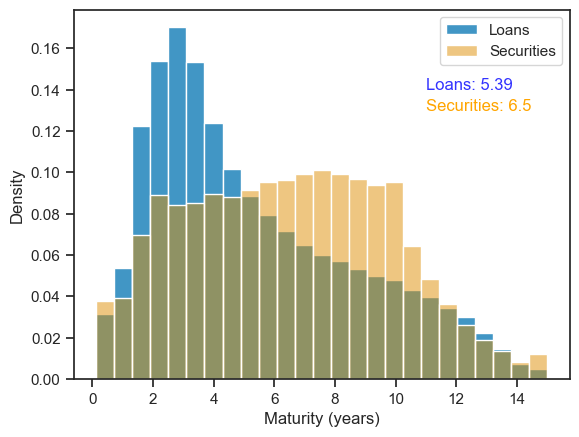

count    619861.000000
mean          6.501768
std           3.320158
min           0.125000
25%           3.798722
50%           6.512730
75%           9.039213
max          15.000000
Name: Security Maturity, dtype: float64
count    619545.000000
mean          5.386390
std           3.360806
min           0.125000
25%           2.718495
50%           4.462871
75%           7.704278
max          15.000000
Name: Loan Maturity, dtype: float64


In [43]:
# use seaborn to plot the distribution of 'Security Maturity':
sns.histplot(data=df, x='Loan Maturity', bins=25, kde=False, stat='density', label='Loans')
sns.histplot(data=df, x='Security Maturity', bins=25, kde=False, stat='density', label='Securities', 
             alpha=0.5)
plt.legend()
plt.ylabel('Density')
plt.xlabel('Maturity (years)')
# write the averages for each variable in the plot:
plt.text(x=11, y=0.14, s=f'Loans: {np.round(df["Loan Maturity"].mean(),2)}', color='blue', alpha=0.8)
plt.text(x=11, y=0.13, s=f'Securities: {np.round(df["Security Maturity"].mean(),2)}', color='orange')
plt.show()

print(df['Security Maturity'].describe())
print(df['Loan Maturity'].describe())

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


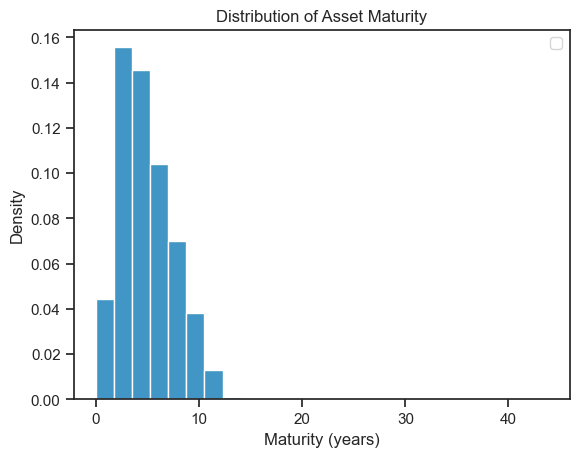

In [44]:
# use seaborn to plot the distribution of 'Security Maturity':
sns.histplot(data=df, x='Asset Maturity', bins=25, kde=False, stat='density', label='')
plt.title('Distribution of Asset Maturity')
plt.legend()
plt.ylabel('Density')
plt.xlabel('Maturity (years)')
plt.show()

In [45]:
low_rates = (
            ((df['Date'] >= '2009-01-01') & (df['Date'] <= '2015-12-31'))|
            ((df['Date'] >= '2020-01-01') & (df['Date'] <= '2022-01-01'))
            )

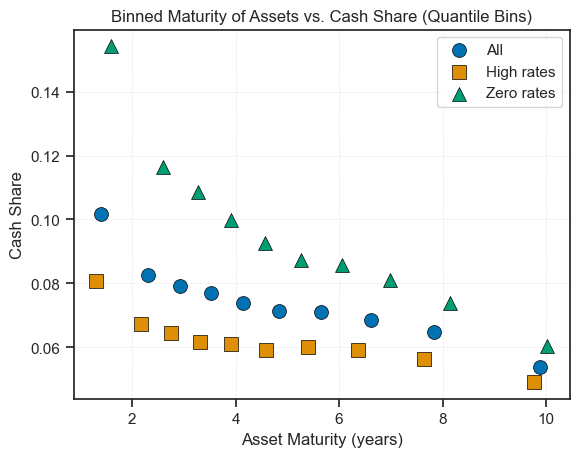

In [46]:
binned_scatter(
df['Asset Maturity'], 
df['Cash Share'], 
q=10, 
#color='blue', 
label='All',
)

binned_scatter(
df.loc[~low_rates, 'Asset Maturity'], 
df.loc[~low_rates, 'Cash Share'], 
q=10, 
#color='blue', 
label='High rates',
marker='s'
)

binned_scatter(
df.loc[low_rates, 'Asset Maturity'], 
df.loc[low_rates, 'Cash Share'], 
q=10, 
#color='blue', 
label='Zero rates',
marker='^'
)

# Plot settings
plt.title('Binned Maturity of Assets vs. Cash Share (Quantile Bins)') 
plt.ylabel('Cash Share')
plt.xlabel('Asset Maturity (years)')
plt.legend()
plt.grid(True, which='both', linestyle='--', lw=0.5, alpha=0.5, color='lightgrey')
plt.show()

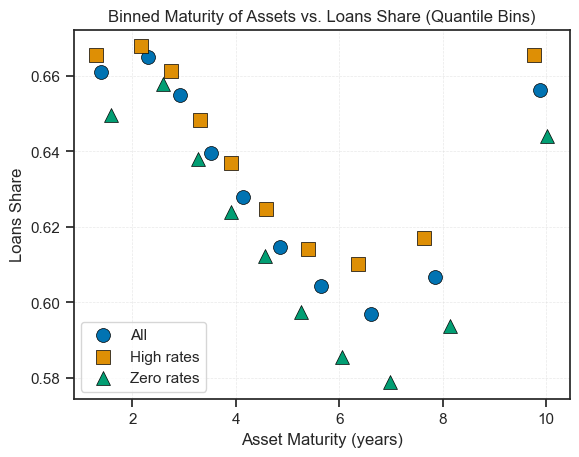

In [47]:
binned_scatter(
df['Asset Maturity'], 
df['Loans Share'], 
q=10, 
#color='blue', 
label='All',
)

binned_scatter(
df.loc[~low_rates, 'Asset Maturity'], 
df.loc[~low_rates, 'Loans Share'], 
q=10, 
#color='blue', 
label='High rates',
marker='s'
)

binned_scatter(
df.loc[low_rates, 'Asset Maturity'], 
df.loc[low_rates, 'Loans Share'], 
q=10, 
#color='blue', 
label='Zero rates',
marker='^'
)

# Plot settings
plt.title('Binned Maturity of Assets vs. Loans Share (Quantile Bins)') 
plt.ylabel('Loans Share')
plt.xlabel('Asset Maturity (years)')
plt.legend()
plt.grid(True, which='both', linestyle='--', lw=0.5, alpha=0.5, color='lightgrey')
plt.show()

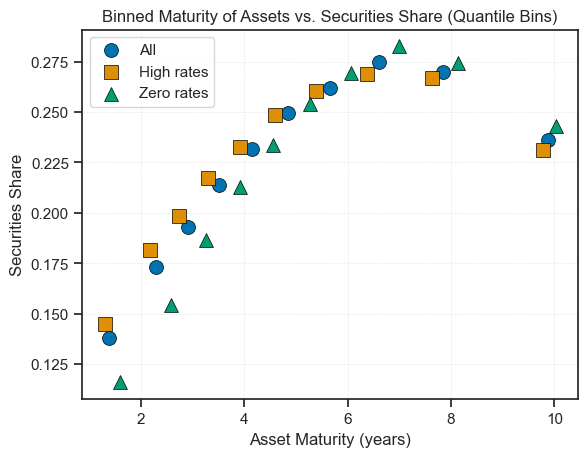

In [48]:
binned_scatter(
df['Asset Maturity'], 
df['Securities Share'], 
q=10, 
#color='blue', 
label='All',
)

binned_scatter(
df.loc[~low_rates, 'Asset Maturity'], 
df.loc[~low_rates, 'Securities Share'], 
q=10, 
#color='blue', 
label='High rates',
marker='s'
)

binned_scatter(
df.loc[low_rates, 'Asset Maturity'], 
df.loc[low_rates, 'Securities Share'], 
q=10, 
#color='blue', 
label='Zero rates',
marker='^'
)

# Plot settings
plt.title('Binned Maturity of Assets vs. Securities Share (Quantile Bins)') 
plt.ylabel('Securities Share')
plt.xlabel('Asset Maturity (years)')
plt.legend()
plt.grid(True, which='both', linestyle='--', lw=0.5, alpha=0.5, color='lightgrey')
plt.show()

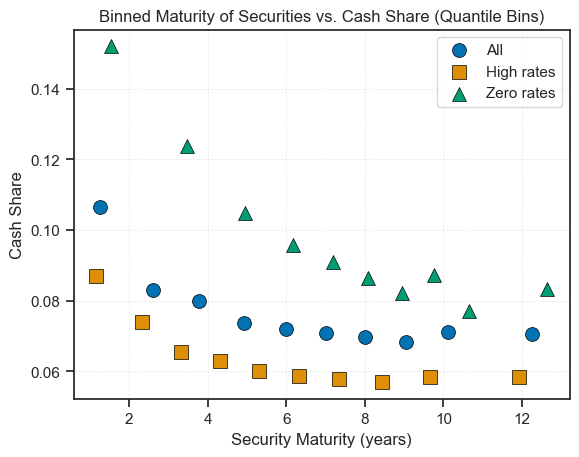

In [49]:
binned_scatter(
df['Security Maturity'], 
df['Cash Share'], 
q=10, 
#color='blue', 
label='All',
)

binned_scatter(
df.loc[~low_rates, 'Security Maturity'], 
df.loc[~low_rates, 'Cash Share'], 
q=10, 
#color='blue', 
label='High rates',
marker='s'
)

binned_scatter(
df.loc[low_rates, 'Security Maturity'], 
df.loc[low_rates, 'Cash Share'], 
q=10, 
#color='blue', 
label='Zero rates',
marker='^'
)

# Plot settings
plt.title('Binned Maturity of Securities vs. Cash Share (Quantile Bins)') 
plt.ylabel('Cash Share')
plt.xlabel('Security Maturity (years)')
plt.legend()
plt.grid(True, which='both', linestyle='--', lw=0.5, alpha=0.5, color='lightgrey')
plt.show()

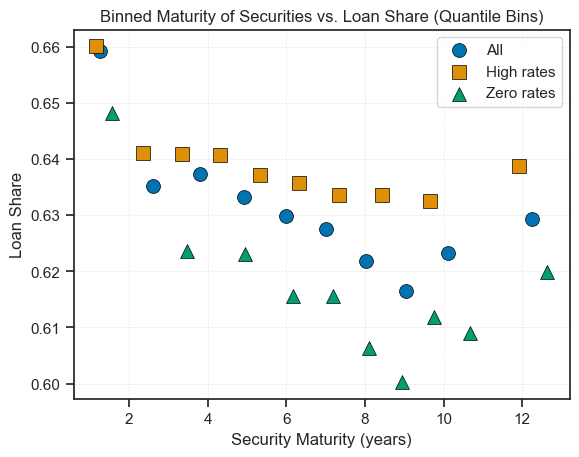

In [50]:
binned_scatter(
df['Security Maturity'], 
df['Loans Share'], 
q=10, 
#color='blue', 
label='All',
)

binned_scatter(
df.loc[~low_rates, 'Security Maturity'], 
df.loc[~low_rates, 'Loans Share'], 
q=10, 
#color='blue', 
label='High rates',
marker='s'
)


binned_scatter(
df.loc[low_rates, 'Security Maturity'], 
df.loc[low_rates, 'Loans Share'], 
q=10, 
#color='blue', 
label='Zero rates',
marker='^'
)


# Plot settings
plt.title('Binned Maturity of Securities vs. Loan Share (Quantile Bins)')
plt.ylabel('Loan Share')
plt.xlabel('Security Maturity (years)')
plt.legend()
plt.grid(True, which='both', linestyle='--', lw=0.5, alpha=0.5, color='lightgrey')
plt.show()

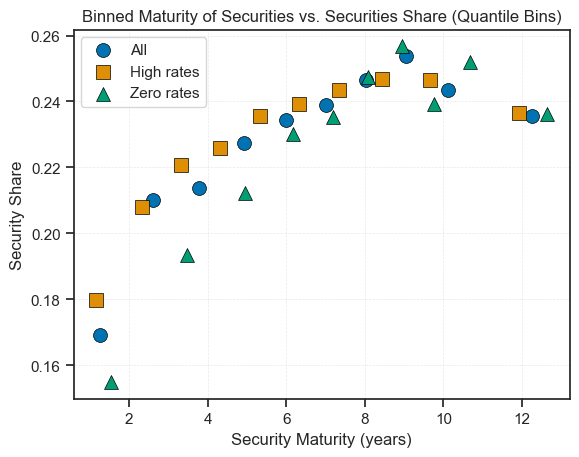

In [51]:
binned_scatter(
df['Security Maturity'], 
df['Securities Share'], 
q=10, 
#color='blue', 
label='All',
)

binned_scatter(
df.loc[~low_rates, 'Security Maturity'], 
df.loc[~low_rates, 'Securities Share'], 
q=10, 
#color='blue', 
label='High rates',
marker='s'
)

binned_scatter(
df.loc[low_rates, 'Security Maturity'], 
df.loc[low_rates, 'Securities Share'], 
q=10, 
#color='blue', 
label='Zero rates',
marker='^'
)




# Plot settings
plt.title('Binned Maturity of Securities vs. Securities Share (Quantile Bins)')
plt.ylabel('Security Share')
plt.xlabel('Security Maturity (years)')
plt.legend()
plt.grid(True, which='both', linestyle='--', lw=0.5, alpha=0.5, color='lightgrey')
plt.show()

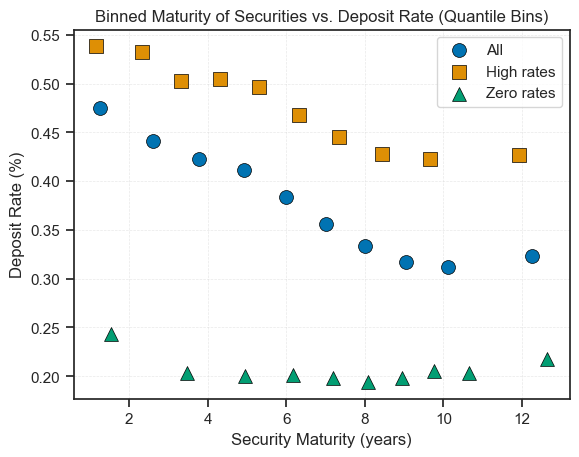

In [52]:
binned_scatter(df['Security Maturity'],
                df['Deposit Rate']*100, 
                q=10, 
                label='All',
                )


binned_scatter(df[~low_rates]['Security Maturity'],
                df[~low_rates]['Deposit Rate']*100, 
                q=10, 
                label='High rates',
                marker='s'
                )

binned_scatter(df[low_rates]['Security Maturity'],
               df[low_rates]['Deposit Rate']*100, 
               q=10, 
               label='Zero rates',
                marker='^'
               )




plt.title('Binned Maturity of Securities vs. Deposit Rate (Quantile Bins)')
plt.ylabel('Deposit Rate (%)')
plt.xlabel('Security Maturity (years)')
plt.legend()
plt.grid(True, which='both', linestyle='--', lw=0.5, alpha=0.5, color='lightgrey')
plt.show()

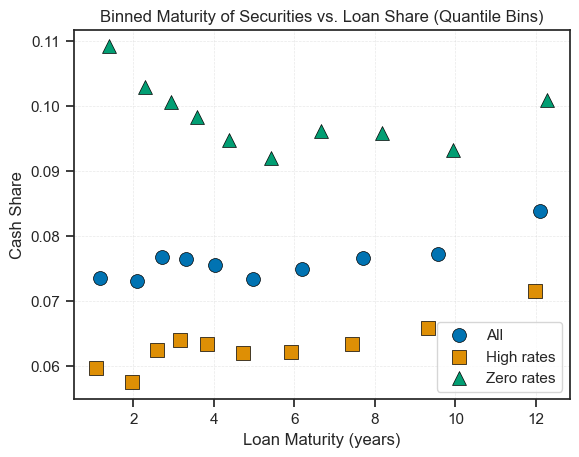

In [53]:
binned_scatter(
df['Loan Maturity'], 
df['Cash Share'], 
q=10, 
#color='blue', 
label='All',
)

binned_scatter(
df.loc[~low_rates, 'Loan Maturity'], 
df.loc[~low_rates, 'Cash Share'], 
q=10, 
#color='blue', 
label='High rates',
marker='s'
)

binned_scatter(
df.loc[low_rates, 'Loan Maturity'], 
df.loc[low_rates, 'Cash Share'], 
q=10, 
#color='blue', 
label='Zero rates',
marker='^'
)


# Plot settings
plt.title('Binned Maturity of Securities vs. Loan Share (Quantile Bins)')
plt.ylabel('Cash Share')
plt.xlabel('Loan Maturity (years)')
plt.legend()
plt.grid(True, which='both', linestyle='--', lw=0.5, alpha=0.5, color='lightgrey')
plt.show()

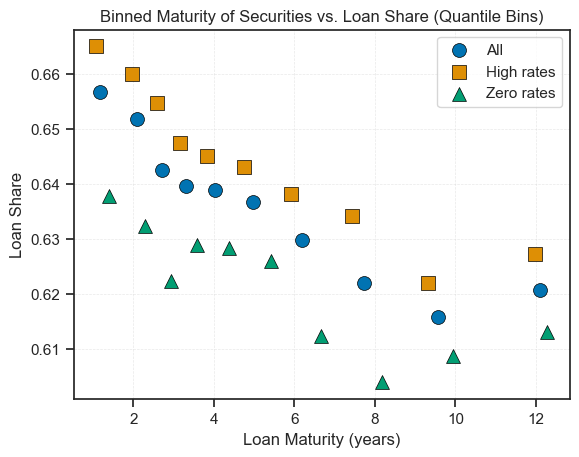

In [54]:
binned_scatter(
df['Loan Maturity'], 
df['Loans Share'], 
q=10, 
#color='blue', 
label='All',
)

binned_scatter(
df.loc[~low_rates, 'Loan Maturity'], 
df.loc[~low_rates, 'Loans Share'], 
q=10, 
#color='blue', 
label='High rates',
marker='s'
)

binned_scatter(
df.loc[low_rates, 'Loan Maturity'], 
df.loc[low_rates, 'Loans Share'], 
q=10, 
#color='blue', 
label='Zero rates',
marker='^'
)

# Plot settings
plt.title('Binned Maturity of Securities vs. Loan Share (Quantile Bins)')
plt.ylabel('Loan Share')
plt.xlabel('Loan Maturity (years)')

plt.legend()
plt.grid(True, which='both', linestyle='--', lw=0.5, alpha=0.5, color='lightgrey')
plt.show()

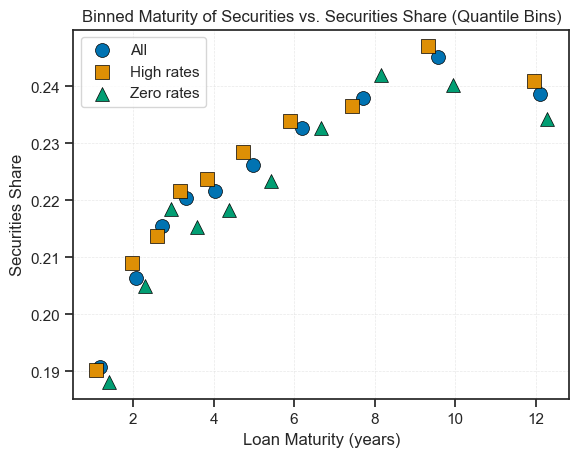

In [55]:
binned_scatter(
df['Loan Maturity'], 
df['Securities Share'], 
q=10, 
#color='blue', 
label='All',
)

binned_scatter(
df.loc[~low_rates, 'Loan Maturity'], 
df.loc[~low_rates, 'Securities Share'], 
q=10, 
#color='blue', 
label='High rates',
marker='s'
)

binned_scatter(
df.loc[low_rates, 'Loan Maturity'], 
df.loc[low_rates, 'Securities Share'], 
q=10, 
#color='blue', 
label='Zero rates',
marker='^'
)

# Plot settings
plt.title('Binned Maturity of Securities vs. Securities Share (Quantile Bins)')
plt.ylabel('Securities Share')
plt.xlabel('Loan Maturity (years)')
plt.legend()
plt.grid(True, which='both', linestyle='--', lw=0.5, alpha=0.5, color='lightgrey')
plt.show()

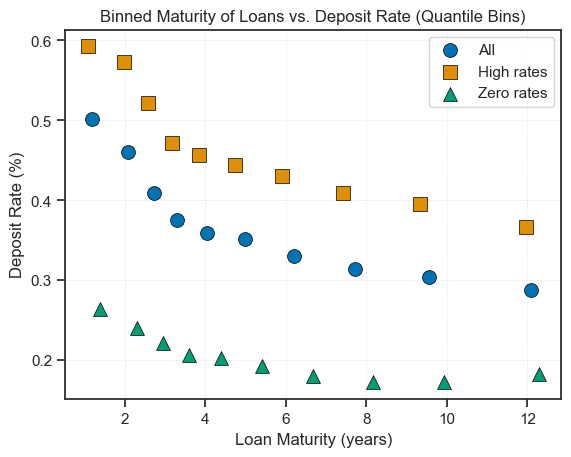

In [56]:
binned_scatter(df['Loan Maturity'],
                df['Deposit Rate']*100, 
                q=10, 
                label='All',
                )

binned_scatter(df[~low_rates]['Loan Maturity'],
                df[~low_rates]['Deposit Rate']*100, 
                q=10, 
                label='High rates',
                marker='s'
                )

binned_scatter(df[low_rates]['Loan Maturity'],
               df[low_rates]['Deposit Rate']*100, 
               q=10, 
               label='Zero rates',
               marker='^'
               )

plt.title('Binned Maturity of Loans vs. Deposit Rate (Quantile Bins)')
plt.ylabel('Deposit Rate (%)')
plt.xlabel('Loan Maturity (years)')
plt.legend()
plt.grid(True, which='both', linestyle='--', lw=0.5, alpha=0.5, color='lightgrey')
plt.show()

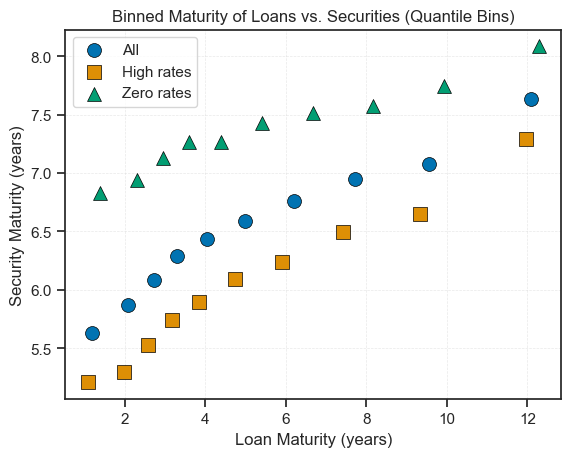

In [57]:
binned_scatter(df['Loan Maturity'],
                df['Security Maturity'], 
                q=10, 
                label='All',
                )

binned_scatter(df[~low_rates]['Loan Maturity'],
                df[~low_rates]['Security Maturity'], 
                q=10, 
                label='High rates',
                marker='s'
                )

binned_scatter(df[low_rates]['Loan Maturity'],
                df[low_rates]['Security Maturity'], 
               q=10, 
               label='Zero rates',
                marker='^'
               )

plt.title('Binned Maturity of Loans vs. Securities (Quantile Bins)')
plt.ylabel('Security Maturity (years)')
plt.xlabel('Loan Maturity (years)')
plt.legend()
plt.grid(True, which='both', linestyle='--', lw=0.5, alpha=0.5, color='lightgrey')
plt.show()

In [ ]:
(df['Deposit Rate']*100).describe()

count    629800.000000
mean          0.384585
std           4.381545
min           0.000015
25%           0.134675
50%           0.300674
75%           0.548251
max        3327.272727
Name: Deposit Rate, dtype: float64

### Responses to EBP Shocks

In [61]:
ebp

,date,gz_spread,ebp,est_prob
0,1973-01-01,1.101827,0.015182,0.219606
1,1973-02-01,1.045423,-0.003915,0.213002
2,1973-03-01,0.995689,-0.094057,0.183436
3,1973-04-01,0.955333,-0.153461,0.165425
4,1973-05-01,1.007393,-0.058243,0.194863
...,...,...,...,...
619,2024-08-01,1.090099,-0.061134,0.193925
620,2024-09-01,1.046020,-0.118405,0.175911
621,2024-10-01,0.980231,-0.363098,0.111304
622,2024-11-01,0.943925,-0.244725,0.140065


### Previous cross-sectional analysis

Analysis was based in growth rates.

In [ ]:
def compute_growth(df, transformations, window=1):
    """
    Compute the log difference of deposits while accounting for mergers, acquisitions, and failures.

    Args:
    - df (pd.DataFrame): Dataframe containing bank-level balance sheet data.
    - transformations (pd.DataFrame): Dataframe containing information about transformations.
    - window (int): Number of quarters before and after a transaction to set as NaN for growth rate.

    Returns:
    - pd.DataFrame: The updated 'df' with a 'deposit_growth' column.
    """
    # Sort the dataframe by bank ID and date to ensure proper lag calculation
    df = df.sort_values(by=['IDRSSD', 'Date'])
    df['Real Deposits'] = df['Total Deposits'] / df['CPI'] * 100
    df['Real Loans'] = df['Total Loans'] / df['CPI'] * 100


    # Calculate log difference (log growth rate) of deposits
    df['Deposit_Growth'] = df.groupby('IDRSSD')['Real Deposits'].transform(lambda x: np.log(x).diff())
    df['Loan_Growth'] = df.groupby('IDRSSD')['Real Loans'].transform(lambda x: np.log(x).diff())
    
    # Create a mask to identify rows to be set to NaN
    for _, row in transformations.iterrows():
        predecessor_id = row['Predecessor ID']
        successor_id = row['Successor ID']
        transaction_date = row['Transaction Date']
        
        # Identify date range around the transaction
        start_date = transaction_date - pd.DateOffset(months=3 * window)
        end_date = transaction_date + pd.DateOffset(months=3 * window)
        
        # Apply NaN to the specified window for predecessor and successor banks
        df.loc[
            ((df['IDRSSD'] == predecessor_id) | (df['IDRSSD'] == successor_id)) & 
            (df['Date'].between(start_date, end_date)),
            'Deposit_Growth'
        ] = np.nan

        df.loc[
            ((df['IDRSSD'] == predecessor_id) | (df['IDRSSD'] == successor_id)) & 
            (df['Date'].between(start_date, end_date)),
            'Loan_Growth'
        ] = np.nan
    
    return df

In [ ]:
df = main[[ 'IDRSSD', 'Date', 'Financial Institution Name',             # Dates and IDS 
            'Total Deposits', 'Deposit Share', 'Total Assets',          # Bank specific quantity variables
            'Total Loans',
            'Deposit Rate', 'Deposit Spread',                           # Bank specific rate variable
            'Cash', 'Securities AC',                                    # Bank specific asset variables
            'FEDFUNDS', 'High Inflation', 'FF Hike', 'Recession',
            'CPI', 'Positive FF Shock'                                  # Macro variables
            ]]

In [ ]:
df.loc[:,'Securities Share'] = df['Securities AC'] / df['Total Assets']

In [ ]:
svb_securities = df[(df['IDRSSD'] == 802866) & (df['Date'] == '2022-12-31')]['Securities Share'].values[0]

In [ ]:
# tell me the IDs of the banks that have a 'Securities Share' above svb_securities:
right_tail_banks = df[(df['Date'] == '2022-12-31') & 
                      (df[df['Date'] == '2022-12-31']['Securities Share'] > svb_securities)]['IDRSSD'].unique()

In [ ]:
right_tail_df = df[ (df['Date'] == '2022-12-31') & 
    (df['IDRSSD'].isin(right_tail_banks))][['Financial Institution Name', 'Total Assets', 'Total Deposits']]

In [ ]:
df[(df['Date'] == '2022-12-31')][['Financial Institution Name', 'Total Assets', 'Total Deposits']].describe()

In [ ]:
right_tail_df.describe()

In [ ]:
# plot the distribution of securities share for 03/31/2023:
sns.histplot(df[df['Date'] == '2022-12-31']['Securities Share'], bins=20, kde=True)
# add a vertical line for the bank with IDRSSD=802866:
plt.axvline(x=df[(df['IDRSSD'] == 802866) & (df['Date'] == '2022-12-31')]['Securities Share'].values[0], 
            color='red', linestyle='--', linewidth=2)       
plt.title('Distribution of Securities Share on 12/31/2022')
plt.show()


In [ ]:
# compute the correlation between FF Hike and Positive FF Shock:
df[['FF Hike', 'Positive FF Shock']].corr()

In [ ]:
df = compute_growth(df, transformations, window=1)

In [ ]:
print(df['Loan_Growth'].describe())
print(df['Loan_Growth'].quantile([0.01, 0.99]))

In [ ]:
print(df['Deposit_Growth'].describe())
print(df['Deposit_Growth'].quantile([0.01, 0.99]))

In [ ]:
# mask the outliers (top and bottom 0.1%) of the distribution of 'Deposit Growth':
df['Deposit_Growth'] = df['Deposit_Growth'].mask((df['Deposit_Growth'] < df['Deposit_Growth'].quantile(0.01)) | 
                                                 (df['Deposit_Growth'] > df['Deposit_Growth'].quantile(0.99)), np.nan)

df['Loan_Growth'] = df['Loan_Growth'].mask((df['Loan_Growth'] < df['Loan_Growth'].quantile(0.01)) | 
                                                 (df['Loan_Growth'] > df['Loan_Growth'].quantile(0.99)), np.nan)


In [ ]:
df['Securities Growth'] = df.groupby('IDRSSD')['Securities AC'].pct_change(fill_method=None)
print(df['Securities Growth'].describe())
# if the 'Securities Growth' is in either top or bottom 1% of the distribution, set it to NaN:
df['Securities Growth'] = df['Securities Growth'].mask((df['Securities Growth'] < df['Securities Growth'].quantile(0.01)) | (df['Securities Growth'] > df['Securities Growth'].quantile(0.99)))
print(df['Securities Growth'].describe())

In [ ]:
df['Real Cash'] = df['Cash'] / df['CPI'] * 100
df['Cash Growth'] = df.groupby('IDRSSD')['Real Cash'].pct_change(fill_method=None)
print(df['Cash Growth'].describe())
# if the 'Securities Growth' is in either top or bottom 1% of the distribution, set it to NaN:
df['Cash Growth'] = df['Cash Growth'].mask((df['Cash Growth'] < df['Cash Growth'].quantile(0.01)) | (df['Cash Growth'] > df['Cash Growth'].quantile(0.99)))
print(df['Cash Growth'].describe())

In [ ]:
def cross_sectional_plots(  df,                     # Dataframe with bank-level data 
                            criteria,               # Criteria to define the interest rate shock
                            num_quantiles=100):     # Number of quantiles for the binned scatter plot

    # Define the interest rate criteria:
    # 1. 'ff_hike': FF Hike is a simple increase in the FFR.
    # 2. 'mp_shock': MP Shock is a positive shock to the FFR.
    if criteria == 'ff_hike':
        # Filter conditions for Expansion and Contraction
        expansion_condition = (
                              (df['Recession'] == 0) & 
                              (df['FF Hike'] == 1) &
                              (df['High Inflation'] == 1)
                              )
        contraction_condition = (
                                (df['Recession'] == 1) &
                                (df['FF Hike'] == 1) &
                                (df['High Inflation'] == 1)
                                )

    elif criteria == 'mp_shock':
        # Filter conditions for Expansion and Contraction
        expansion_condition = (
                            (df['Recession'] == 0) &
                            (df['Positive FF Shock'] == 1) &
                            (df['High Inflation'] == 1)
                            )
        contraction_condition = (
                            (df['Recession'] == 1) &
                            (df['Positive FF Shock'] == 1) & 
                            (df['High Inflation'] == 1)
                            )

    else:
        print('Criteria not found')
        return None
    
    # --------------------------------- Histograms --------------------------------- #

    # make a histogram of the de-trended loans when the inflation is high, FF hike and Boom vs. Recession:
    lin = np.linspace(-0.25, 0.25, 150)
    plt.figure(figsize=(12, 6))
    sns.histplot(df[expansion_condition]['Loan_Growth'], 
                label='Expansion', bins=lin, stat='density', alpha=0.6)
    plt.axvline(df[expansion_condition]['Loan_Growth'].mean(), linestyle='--', linewidth=2, color='blue')
    sns.histplot(df[contraction_condition]['Loan_Growth'], 
                label='Contraction', bins=lin, alpha=0.6, stat='density')
    plt.axvline(df[contraction_condition]['Loan_Growth'].mean(), linestyle='--', linewidth=2, color='orange')
    plt.title('Loan Growth (High Inflation, FF Hike)')
    plt.xlabel('Loan Growth')
    plt.ylabel('Density')
    plt.legend()
    # print the std deviation of both distributions in the (-0.2,8) coordinate:
    plt.text(0.1, 7, 'Mean Expansion:             ' + str(round(df[expansion_condition]['Loan_Growth'].mean(), 4)))
    plt.text(0.1, 6.5, 'Std. Expansion:             ' + str(round(df[expansion_condition]['Loan_Growth'].std(), 4)))
    plt.text(0.1, 6, 'Mean Contraction:           ' + str(round(df[contraction_condition]['Loan_Growth'].mean(), 4)))
    plt.text(0.1, 5.5, 'Std. Contraction:           ' + str(round(df[contraction_condition]['Loan_Growth'].std(), 4)))
    plt.grid(True, which='both', linestyle='--', lw=0.5, alpha=0.5, color='lightgrey')
    plt.xlim(-0.13, 0.22)
    plt.show()

    #-------------------------------------------------------------------------------------------------#

    lin = np.linspace(-0.25, 0.25, 150)
    plt.figure(figsize=(12, 6))
    sns.histplot(df[expansion_condition]['Deposit_Growth'], 
                label='Expansion', bins=lin, stat='density', alpha=0.6)
    plt.axvline(df[expansion_condition]['Deposit_Growth'].mean(), linestyle='--', linewidth=2, color='blue')
    sns.histplot(df[contraction_condition]['Deposit_Growth'], 
                label='Contraction', bins=lin, alpha=0.6, stat='density')
    plt.axvline(df[contraction_condition]['Deposit_Growth'].mean(), linestyle='--', linewidth=2, color='orange')
    plt.title('Deposits Growth (High Inflation, FF Hike)')
    plt.xlabel('Deposits Growth')
    plt.ylabel('Density')
    plt.legend()
    # print the std deviation of both distributions in the (-0.2,8) coordinate:
    plt.text(0.1, 7, 'Mean Expansion:             ' + str(round(df[expansion_condition]['Deposit_Growth'].mean(), 4)))
    plt.text(0.1, 6.5, 'Std. Expansion:             ' + str(round(df[expansion_condition]['Deposit_Growth'].std(), 4)))
    plt.text(0.1, 6, 'Mean Contraction:           ' + str(round(df[contraction_condition]['Deposit_Growth'].mean(), 4)))
    plt.text(0.1, 5.5, 'Std. Contraction:           ' + str(round(df[contraction_condition]['Deposit_Growth'].std(), 4)))
    plt.grid(True, which='both', linestyle='--', lw=0.5, alpha=0.5, color='lightgrey')
    plt.xlim(-0.13, 0.22)
    plt.show()

    #-------------------------------------------------------------------------------------------------#

    # make a histogram of the de-trended loans when the inflation is high, FF hike and Boom vs. Recession:
    plt.figure(figsize=(12, 6))
    sns.histplot(df[expansion_condition]['Securities Growth'], 
                label='Expansion', bins=lin, stat='density', alpha=0.6)
    plt.axvline(df[expansion_condition]['Securities Growth'].mean(), linestyle='--', linewidth=2, color='blue')
    sns.histplot(df[contraction_condition]['Securities Growth'], 
                label='Contraction', bins=lin, alpha=0.6, stat='density')
    plt.axvline(df[contraction_condition]['Securities Growth'].mean(), linestyle='--', linewidth=2, color='orange')
    plt.title('Securities Growth (High Inflation, FF Hike)')
    plt.xlabel('Securities Growth')
    plt.ylabel('Density')
    plt.legend()
    # print the std deviation of both distributions in the (-0.2,8) coordinate:
    plt.text(0.1, 7.5, 'Mean Expansion:             ' + str(round(df[expansion_condition]['Securities Growth'].mean(), 4)))
    plt.text(0.1, 6.5, 'Std. Expansion:             ' + str(round(df[expansion_condition]['Securities Growth'].std(), 4)))
    plt.text(0.1, 5.5, 'Mean Contraction:           ' + str(round(df[contraction_condition]['Securities Growth'].mean(), 4)))
    plt.text(0.1, 4.5, 'Std. Contraction:           ' + str(round(df[contraction_condition]['Securities Growth'].std(), 4)))
    plt.grid(True, which='both', linestyle='--', lw=0.5, alpha=0.5, color='lightgrey')
    plt.xlim(-0.25, 0.25)
    plt.show()

    #-------------------------------------------------------------------------------------------------#

    # make a histogram of the de-trended loans when the inflation is high, FF hike and Boom vs. Recession:
    plt.figure(figsize=(12, 6))
    lin = np.linspace(df['Cash Growth'].min(), 2, 150)
    sns.histplot(df[expansion_condition]['Cash Growth'], 
                label='Expansion', bins=lin, stat='density', alpha=0.6)
    plt.axvline(df[expansion_condition]['Cash Growth'].mean(), linestyle='--', linewidth=2, color='blue')
    sns.histplot(df[contraction_condition]['Cash Growth'], 
                label='Contraction', bins=lin, alpha=0.6, stat='density')
    plt.axvline(df[contraction_condition]['Cash Growth'].mean(), linestyle='--', linewidth=2, color='orange')
    plt.title('Cash Growth (High Inflation, FF Hike)')
    plt.xlabel('Cash Growth')
    plt.ylabel('Density')
    plt.legend()
    # print the std deviation of both distributions in the (-0.2,8) coordinate:
    # print the std deviation of both distributions in the (-0.2,8) coordinate:
    plt.text(1, 1.4, 'Mean Expansion:             ' + str(round(df[expansion_condition]['Cash Growth'].mean(), 4)))
    plt.text(1, 1.3, 'Std. Expansion:             ' + str(round(df[expansion_condition]['Cash Growth'].std(), 4)))
    plt.text(1, 1.2, 'Mean Contraction:           ' + str(round(df[contraction_condition]['Cash Growth'].mean(), 4)))
    plt.text(1, 1.1, 'Std. Contraction:           ' + str(round(df[contraction_condition]['Cash Growth'].std(), 4)))
    plt.grid(True, which='both', linestyle='--', lw=0.5, alpha=0.5, color='lightgrey')
    plt.show()


    # --------------------------------- Scatter Plots --------------------------------- #
    #-------------------------------------------------------------------------------------------------#

    # Create the figure
    plt.figure(figsize=(12, 6))

    # Binned scatter for expansion
    binned_scatter(
    df.loc[expansion_condition, 'Loan_Growth'], 
    df.loc[expansion_condition, 'Securities Growth'], 
    q=num_quantiles, 
    #color='blue', 
    label='Expansion'
    )

    # Binned scatter for contraction
    binned_scatter(
    df.loc[contraction_condition, 'Loan_Growth'], 
    df.loc[contraction_condition, 'Securities Growth'], 
    q=num_quantiles, 
    #color='orange', 
    label='Contraction'
    )

    # Plot settings
    plt.title('Binned Loan Growth vs. Securities Growth (Quantile Bins)')
    plt.ylabel('Loan Growth')
    plt.xlabel('Securities Growth')
    plt.ylim(-0.05, 0.12)
    plt.legend()
    plt.grid(True, which='both', linestyle='--', lw=0.5, alpha=0.5, color='lightgrey')
    plt.show()

    #-------------------------------------------------------------------------------------------------#
    # Create the figure
    plt.figure(figsize=(12, 6))

    # Binned scatter for expansion
    binned_scatter(
    df.loc[expansion_condition, 'Deposit_Growth'], 
    df.loc[expansion_condition, 'Loan_Growth'], 
    q=num_quantiles, 
    #color='blue', 
    label='Expansion'
    )

    # Binned scatter for contraction
    binned_scatter(
    df.loc[contraction_condition, 'Deposit_Growth'], 
    df.loc[contraction_condition, 'Loan_Growth'], 
    q=num_quantiles, 
    #color='orange', 
    label='Contraction'
    )

    # Plot settings
    plt.title('Binned Deposits Growth vs. Loan Growth (Quantile Bins)')
    plt.ylabel('Loan Growth')
    plt.xlabel('Deposits Growth')
    plt.ylim(-0.01, 0.05)
    plt.xlim(-0.1, 0.2)
    plt.legend()
    plt.grid(True, which='both', linestyle='--', lw=0.5, alpha=0.5, color='lightgrey')
    plt.show()

    #-------------------------------------------------------------------------------------------------#
    # Create the figure
    plt.figure(figsize=(12, 6))

    # Binned scatter for expansion
    binned_scatter(
    df.loc[expansion_condition, 'Deposit_Growth'], 
    df.loc[expansion_condition, 'Cash Growth'], 
    q=num_quantiles, 
    #color='blue', 
    label='Expansion'
    )

    # Binned scatter for contraction
    binned_scatter(
    df.loc[contraction_condition, 'Deposit_Growth'], 
    df.loc[contraction_condition, 'Cash Growth'], 
    q=num_quantiles, 
    #color='orange', 
    label='Contraction'
    )

    # Plot settings
    plt.title('Binned Deposits Growth vs. Cash Growth (Quantile Bins)')
    plt.ylabel('Cash Growth')
    plt.xlabel('Deposits Growth')
    plt.legend()
    plt.grid(True, which='both', linestyle='--', lw=0.5, alpha=0.5, color='lightgrey')
    plt.show()

    #-------------------------------------------------------------------------------------------------#
    # Create the figure
    plt.figure(figsize=(12, 6))

    # Binned scatter for expansion
    binned_scatter(
    df.loc[expansion_condition, 'Deposit_Growth'], 
    df.loc[expansion_condition, 'Securities Growth'], 
    q=num_quantiles, 
    #color='blue', 
    label='Expansion'
    )

    # Binned scatter for contraction
    binned_scatter(
    df.loc[contraction_condition, 'Deposit_Growth'], 
    df.loc[contraction_condition, 'Securities Growth'], 
    q=num_quantiles, 
    #color='orange', 
    label='Contraction'
    )

    # Plot settings
    plt.title('Binned Deposits Growth vs. Securities Growth (Quantile Bins)')
    plt.ylabel('Securities Growth')
    plt.xlabel('Deposits Growth')
    plt.legend()
    plt.grid(True, which='both', linestyle='--', lw=0.5, alpha=0.5, color='lightgrey')
    plt.show()

In [ ]:
cross_sectional_plots(df, 'ff_hike', num_quantiles=50)

In [ ]:
cross_sectional_plots(df, 'mp_shock', num_quantiles=50)